In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import PyPDF2
import zipfile
sns.set(font_scale=1.2, style='white')

In [12]:
def cleaning(df, user_type=None, add_user_age=True):

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    df = df.dropna(subset=['birthyear'])
    
    if user_type is not None:
        assert user_type in ['Subscriber', 'Customer']
        df = df.query('usertype==@user_type')

    df.loc[:, 'starttime'] = pd.to_datetime(df.starttime)
    df.loc[:, 'stoptime'] = pd.to_datetime(df.stoptime)
    df.loc[:, 'year'] = df.starttime.dt.year
    df.loc[:, 'hour'] = df.starttime.dt.hour
    df.loc[:, 'weekday'] = df.starttime.dt.weekday.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')
    df.loc[:, 'weekday-hour'] = df.hour.astype(str).str.zfill(2).str.cat(df.weekday, sep='-')

    if add_user_age:
        df.loc[:, 'user_age'] = df.year - df.birthyear
        df = df.query('user_age>=0')
        df = df.query('user_age<=80')

    return df

In [4]:
def load_data(date=None, date_from=None, date_to=None, clean=True):
    """
        date: (str) e.g., '201701'
    """
    if date is not None:
        zip_file = zipfile.ZipFile(f'../rawdata/{date}-citibike-tripdata.csv.zip')
        data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
        # data = pd.read_csv(f'../rawdata/{date}-citibike-tripdata.csv.zip', compression='zip')
        if clean:
            return cleaning(data)
        else:
            return data

    else:
        return pd.concat([load_data(date.strftime("%Y%m"))
            for date in pd.date_range(start=date_from, end=date_to, freq='M')])

In [5]:
def plot_user_age(df, ax0, ax1=None, ax2=None):

    df.user_age.hist(ax=ax0)
    ax0.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax0.set_xlabel("User Age")
    ax0.set_ylabel("# users")

    if ax1 is not None:
        df.query('usertype=="Customer"').user_age.hist(ax=ax1)
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax1.set_xlabel("User Age")
        ax1.set_ylabel("# customers")

    if ax2 is not None:
        df.query('usertype=="Subscriber"').user_age.hist(ax=ax2)
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax2.set_xlabel("User Age")
        ax2.set_ylabel("# subscribers")


In [6]:
def plot_sequence(df, ax, freq='H', attr=None, index='starttime'):
    df.set_index(index).groupby(pd.Grouper(freq=freq)).size().plot(ax=ax)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_ylabel('# trips')
    ax.grid()

In [7]:
def plot_weekly_counts(df, ax, key='weekday'):
    sns.boxplot(data=df, ax=ax, x=key, y='user_age', palette='Set1', order=sorted(df[key].unique()))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return g

In [13]:
df = load_data('201701')
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,2017,0,6-Sun,00-6-Sun,52.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2017,0,6-Sun,00-6-Sun,30.0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163,Central Park West & W 68 St,40.773407,-73.977825,3163,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1,2017,0,6-Sun,00-6-Sun,17.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,Broadway & W 60 St,40.769155,-73.981918,479,9 Ave & W 45 St,40.760193,-73.991255,27294,Subscriber,1973.0,1,2017,0,6-Sun,00-6-Sun,44.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362,Broadway & W 37 St,40.751726,-73.987535,445,E 10 St & Avenue A,40.727408,-73.981420,23288,Subscriber,1977.0,2,2017,0,6-Sun,00-6-Sun,40.0


In [9]:
clean_df = cleaning(df)
clean_df.shape

(697144, 20)

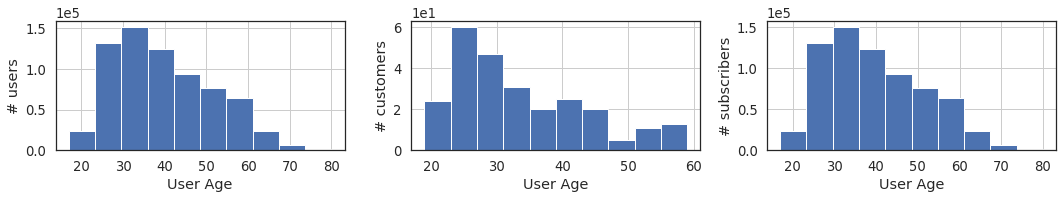

In [220]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
plot_user_age(clean_df, *ax)
fig.tight_layout()

In [221]:
df.nunique()

tripduration                9087
starttime                1000817
stoptime                 1004993
startstationid               624
startstationname             624
startstationlatitude         624
startstationlongitude        624
endstationid                 632
endstationname               632
endstationlatitude           632
endstationlongitude          632
bikeid                      9967
usertype                       2
birthyear                     65
gender                         3
year                           1
hour                          24
weekday                        7
weekday-hour                 168
user_age                      65
dtype: int64

In [222]:
def describe(trips):

    unique_count = trips.nunique()
    missing_value_rate = trips.isna().sum(axis=0) / trips.shape[0] * 100

    return pd.DataFrame({
        'unique_count': unique_count,
        'missing_value_rate': missing_value_rate,
    })

In [223]:
describe(df)

,unique_count,missing_value_rate
tripduration,9087,0.0
starttime,1000817,0.0
stoptime,1004993,0.0
startstationid,624,0.0
startstationname,624,0.0
startstationlatitude,624,0.0
startstationlongitude,624,0.0
endstationid,632,0.0
endstationname,632,0.0
endstationlatitude,632,0.0


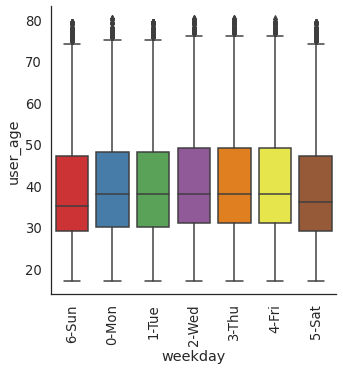

In [224]:
g = sns.catplot(data=clean_df, x='weekday', y='user_age', kind='box', palette='Set1')
g.set_xticklabels(rotation=90)

In [174]:
clean_df

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,year,weekday,user_age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,2017,6-Sun,52.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2017,6-Sun,30.0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163,Central Park West & W 68 St,40.773407,-73.977825,3163,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1,2017,6-Sun,17.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,Broadway & W 60 St,40.769155,-73.981918,479,9 Ave & W 45 St,40.760193,-73.991255,27294,Subscriber,1973.0,1,2017,6-Sun,44.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362,Broadway & W 37 St,40.751726,-73.987535,445,E 10 St & Avenue A,40.727408,-73.981420,23288,Subscriber,1977.0,2,2017,6-Sun,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726671,340,2017-01-31 23:59:14,2017-02-01 00:04:55,267,Broadway & W 36 St,40.750977,-73.987654,527,E 33 St & 2 Ave,40.744023,-73.976056,17133,Subscriber,1977.0,1,2017,1-Tue,40.0
726672,338,2017-01-31 23:59:23,2017-02-01 00:05:01,3092,Berry St & N 8 St,40.719009,-73.958525,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,18810,Subscriber,1972.0,1,2017,1-Tue,45.0
726673,79,2017-01-27 04:59:49,2017-01-27 05:01:08,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,2017,4-Fri,25.0
726674,711,2017-01-27 06:23:29,2017-01-27 06:35:21,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,2017,4-Fri,25.0


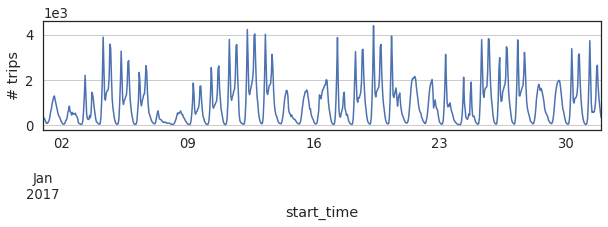

In [175]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_sequence(clean_df, ax=ax)

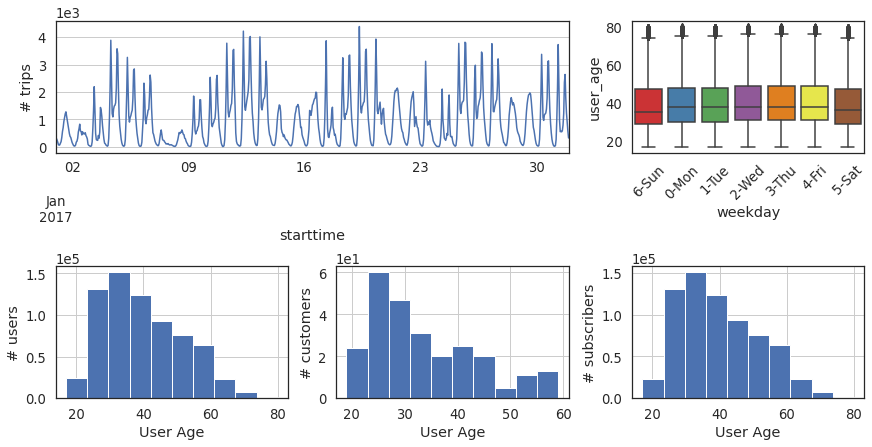

In [267]:
fig  = plt.figure(figsize=(12, 12), constrained_layout=True)
spec = fig.add_gridspec(5, 3)

ax0 = fig.add_subplot(spec[0, :-1])
plot_sequence(clean_df, ax=ax0)

ax1 = fig.add_subplot(spec[0, -1])
plot_weekly_counts(clean_df, ax1)

ax2 = [fig.add_subplot(spec[1, i]) for i in range(3)]
plot_user_age(clean_df, ax2[0], ax1=ax2[1], ax2=ax2[2])

# fig.tight_layout()

In [279]:
def plot_overview(df):
    fig  = plt.figure(figsize=(15, 10), constrained_layout=True)
    spec = fig.add_gridspec(2, 3)

    ax0 = fig.add_subplot(spec[0, :-1])
    plot_sequence(df, ax=ax0)

    ax1 = fig.add_subplot(spec[0, -1])
    plot_weekly_counts(df, ax1)

    ax2 = [fig.add_subplot(spec[1, i]) for i in range(3)]
    plot_user_age(df, ax2[0], ax1=ax2[1], ax2=ax2[2])

    # fig.tight_layout()
    return fig

In [280]:
def plot_overview_all(start='2017-01-01', end='2021-02-01', freq='M'):

    st_date = pd.date_range(start=start, end=end, freq=freq)
    ed_date = st_date.shift(1)

    merger = PyPDF2.PdfFileMerger()
    tmp_files = []

    for i, (st, ed) in tqdm.tqdm(enumerate(zip(st_date, ed_date)), total=len(st_date)):
        
        if len(freq) > 1:
            df = load_data(date_from=st, date_to=ed)
        else:
            df = load_data(date=st.strftime('%Y%m'))

        df = cleaning(df)

        fig = plot_overview(df)
        fig_name = f'tmp_overview_{i}.pdf'
        fig.savefig(fig_name)
        merger.append(fig_name)
        tmp_files.append(fig_name)

        plt.clf()
        plt.close()
        del df

    merger.write('tripdata-overview.pdf')
    merger.close()

    for fn in tmp_files:
        os.remove(fn)

In [292]:
plot_overview_all(start='2019-01-01')

100%|██████████| 25/25 [06:34<00:00, 15.77s/it]


In [18]:
clean_df.groupby('startstationid').size().sort_values().iloc[-500:]

startstationid
3297     284
3384     287
3300     289
3329     295
421      297
        ... 
490     4688
402     4824
497     4980
435     5359
519     8573
Length: 500, dtype: int64

In [19]:
clean_df.groupby('endstationid').size().sort_values().iloc[-500:]

endstationid
421      263
3094     263
397      267
3088     268
278      268
        ... 
490     4753
435     5412
497     5527
402     5801
519     8631
Length: 500, dtype: int64